In [194]:
import os, sys
import numpy as np

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

In [195]:
from e_nose import file_reader 
from e_nose import data_processing as dp
from e_nose import data_visualization

%reload_ext autoreload
%autoreload 2

In [196]:
from sklearn.decomposition import PCA

# Process data

read in data from a specific file

or all files from a from a directory

In [197]:
functionalisations, correct_channels, data = file_reader.read_all_files_in_folder('../data')

../data/data_cream_cheese_raisin_glogg_rucola_sunflower_oil_green_tea_5_loops_for_5.0_min_referenceTime_30.0_min_2020-1-21_21_58.csv


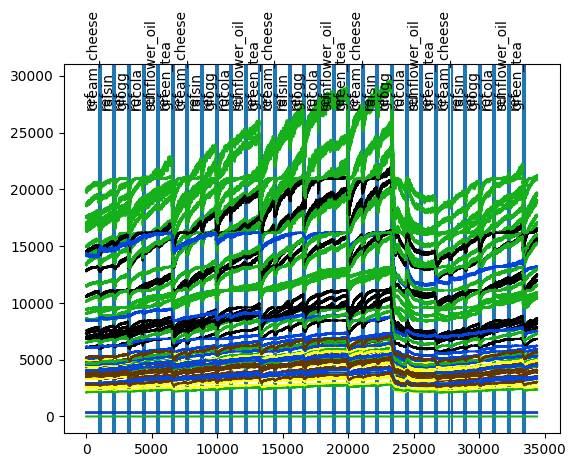

../data/data_1_loops_for_0.0_min_referenceTime_1440.0_min_2020-1-16_22_30.csv


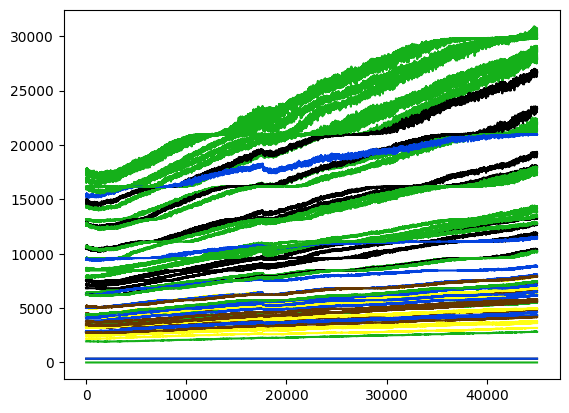

../data/data_walnut_onion_fresh_noodle_tillsitter_cheese_pepper_red_cabbage_3_loops_for_5.0_min_referenceTime_30.0_min_2020-1-12_15_18.csv


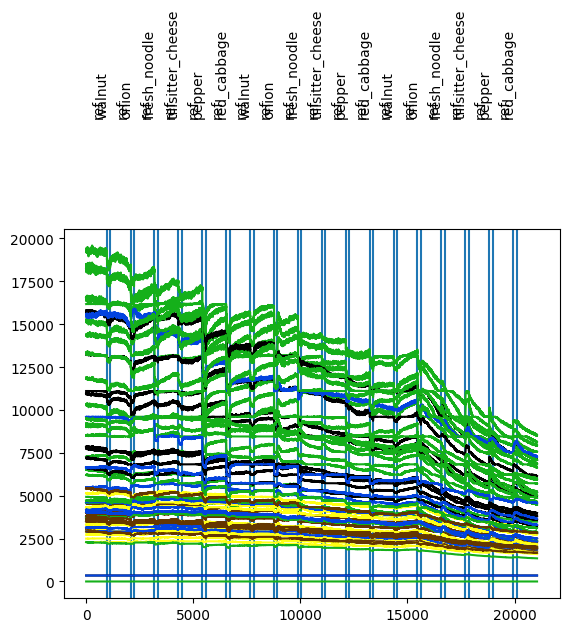

../data/data_cream_cheese_raisin_glogg_rucola_sunflower_oil_green_tea_5_loops_for_5.0_min_referenceTime_30.0_min_2020-1-19_18_59.csv


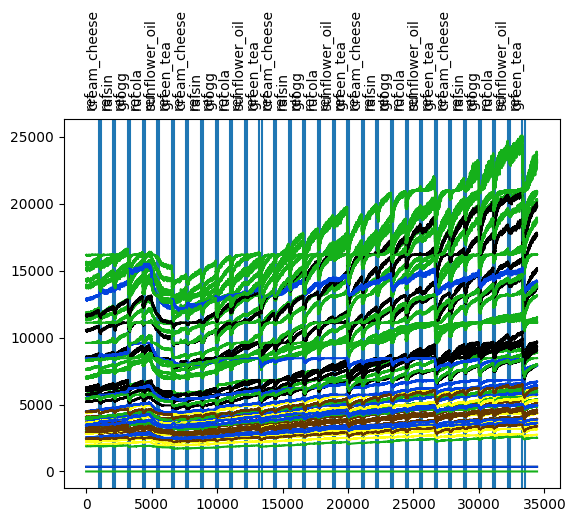

../data/data_wodka_orange_juice_red_wine_lemon_juice_coffee_garlic_10_loops_for_10.0_min_2020-01-03_11-08.csv


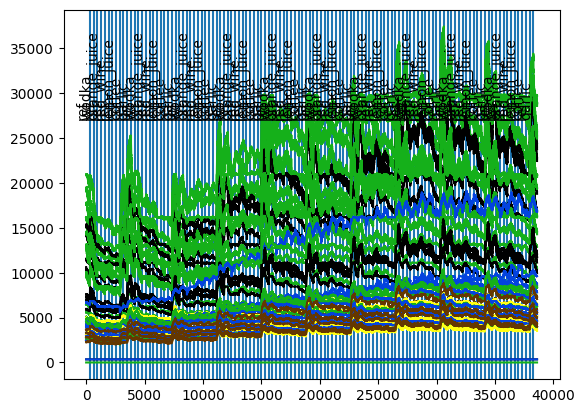

In [198]:
data_visualization.draw_all_channel_data_as_line(data, functionalisations)

../data/data_cream_cheese_raisin_glogg_rucola_sunflower_oil_green_tea_5_loops_for_5.0_min_referenceTime_30.0_min_2020-1-21_21_58.csv


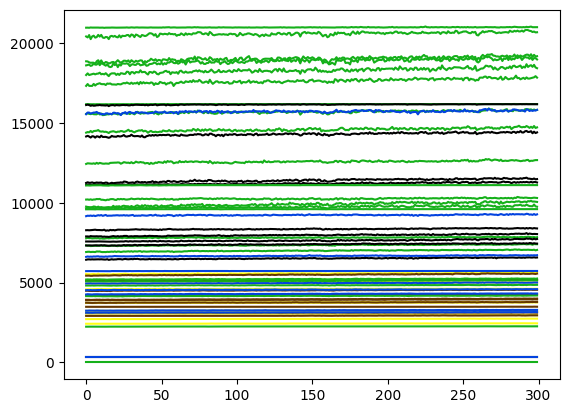

../data/data_1_loops_for_0.0_min_referenceTime_1440.0_min_2020-1-16_22_30.csv


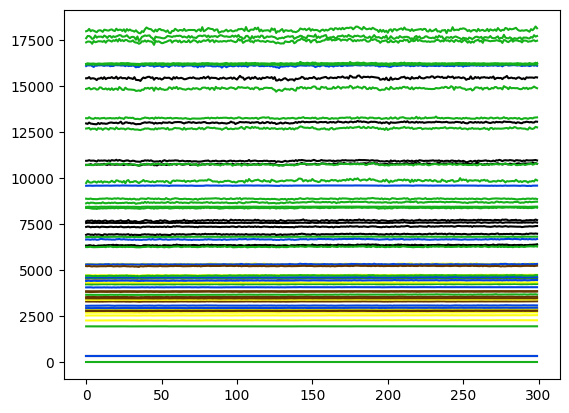

../data/data_walnut_onion_fresh_noodle_tillsitter_cheese_pepper_red_cabbage_3_loops_for_5.0_min_referenceTime_30.0_min_2020-1-12_15_18.csv


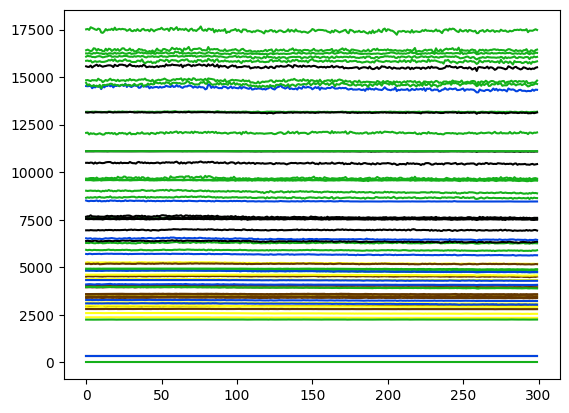

../data/data_cream_cheese_raisin_glogg_rucola_sunflower_oil_green_tea_5_loops_for_5.0_min_referenceTime_30.0_min_2020-1-19_18_59.csv


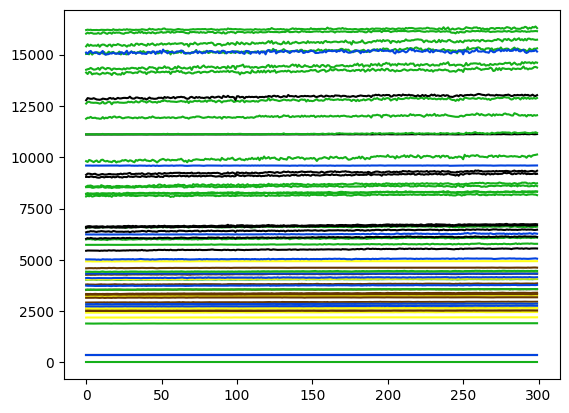

../data/data_wodka_orange_juice_red_wine_lemon_juice_coffee_garlic_10_loops_for_10.0_min_2020-01-03_11-08.csv


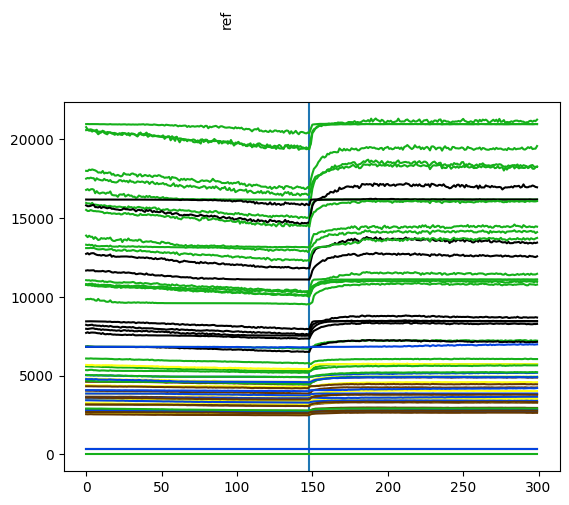

In [199]:
data_visualization.draw_all_channel_data_as_line(data, functionalisations, 4000 , 4300)

In [200]:
measurements_per_file = {}
for file in data:
    measurements_per_file[file] = dp.get_labeled_measurements(data[file], correct_channels, functionalisations)

In [201]:
measurements = []
for file in measurements_per_file:
    print("file: ",file)
    adding = dp.standardize_measurements(measurements_per_file[file])
    if adding is not None:
        measurements.extend(adding)

print(len(measurements))

file:  ../data/data_cream_cheese_raisin_glogg_rucola_sunflower_oil_green_tea_5_loops_for_5.0_min_referenceTime_30.0_min_2020-1-21_21_58.csv
file:  ../data/data_1_loops_for_0.0_min_referenceTime_1440.0_min_2020-1-16_22_30.csv
file:  ../data/data_walnut_onion_fresh_noodle_tillsitter_cheese_pepper_red_cabbage_3_loops_for_5.0_min_referenceTime_30.0_min_2020-1-12_15_18.csv
file:  ../data/data_cream_cheese_raisin_glogg_rucola_sunflower_oil_green_tea_5_loops_for_5.0_min_referenceTime_30.0_min_2020-1-19_18_59.csv
file:  ../data/data_wodka_orange_juice_red_wine_lemon_juice_coffee_garlic_10_loops_for_10.0_min_2020-01-03_11-08.csv
138


In [202]:
labels = list(set([m.label for m in measurements]))
measurements_by_labels = {}
for i, l in enumerate(labels):
    measurements_by_labels[l] = []
for m in measurements:
    for i, l in enumerate(labels):
        if m.label == l:
            measurements_by_labels[l].append(m)  

# KNN

## Prepare Data

In [203]:
num_classes = len(labels)
num_runs = 10
num_dim = measurements[0].get_data().shape[1]

In [204]:
data = np.zeros([num_classes, num_runs, num_dim])
for c, label in enumerate(labels):
    for run in range(num_runs):
        # last 5 measurements averaged
        #data[c, run, :] = np.mean(measurements_by_labels[label][run].get_data()[-5:, :], axis=0)
        
        # measurement at 100 sec
        data[c, run, :] = measurements_by_labels[label][run].get_data()[55, :]

IndexError: list index out of range

## PCA

In [ ]:
pca = PCA(3)
data_transformed = pca.fit_transform(data.reshape(-1, data.shape[-1]))
data_transformed = data_transformed.reshape(num_classes, num_runs, -1)
print(data_transformed.shape)

In [ ]:
num_dim_new = data_transformed.shape[-1]
centroids = np.zeros([num_classes, num_dim_new])
for c, label in enumerate(labels):
    centroids[c, :] = np.mean(data_transformed[c, :, :], axis=0)
print(centroids.shape)

In [ ]:
#def euk_dist(a, b):
#    return np.sqrt(np.sum(np.square(a-b)))

In [ ]:
#test classification
#run = 3
#lab_num_gt = 4
#data_sample = data[lab_num_gt, run, :]
#best_diff = 99999.
#best_c = None

#print('diff sample with num ', run, ' from ', labels[lab_num_gt], ' to class ...')
#for c in range(len(labels)):
#    diff = euk_dist(data_sample, centroids[c])
#    print('...', labels[c], ' is ', diff)
#    if diff < best_diff:
#        best_diff = diff
#        best_c = c
#print('class gt: ', labels[lab_num_gt])
#print('class pred: ', labels[best_c])

In [ ]:
from sklearn.neighbors import NearestNeighbors

data_flattened = data_transformed.reshape(-1, data_transformed.shape[-1])
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree', metric='euclidean').fit(data_flattened)
distances, indices = nbrs.kneighbors(data_flattened)
distances = distances[:,1:]
neighbor_indices = np.reshape(indices[:, 1:], (num_classes, num_runs, -1))
#print(neighbor_indices)
neighbor_classes = (neighbor_indices/num_runs).astype(int)
#print(neighbor_classes)

In [ ]:
def get_classes(classes):
    unique_classes, counts = np.unique(classes, return_counts=True)
    winner_index = np.argwhere(counts == np.amax(counts)).flatten()
    return unique_classes[winner_index]

In [ ]:
correct_counter = 0
false_counter = 0
unknown_counter = 0

for c in range(num_classes):
    for r in range(num_runs):
        pred_classes = get_classes(neighbor_classes[c, r])
        if pred_classes.size == 1:
            if pred_classes[0] == c:
                correct_counter += 1
            else:
                false_counter += 1
        else:
            unknown_counter += 1
        
accuracy = correct_counter / (correct_counter + false_counter + unknown_counter)
print("accuracy: ", accuracy)